# Explore here

🔹 Dataset Shape: (768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

🔹 Dataset Info:
 None

🔹 Summary Statistics:
                           count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose      

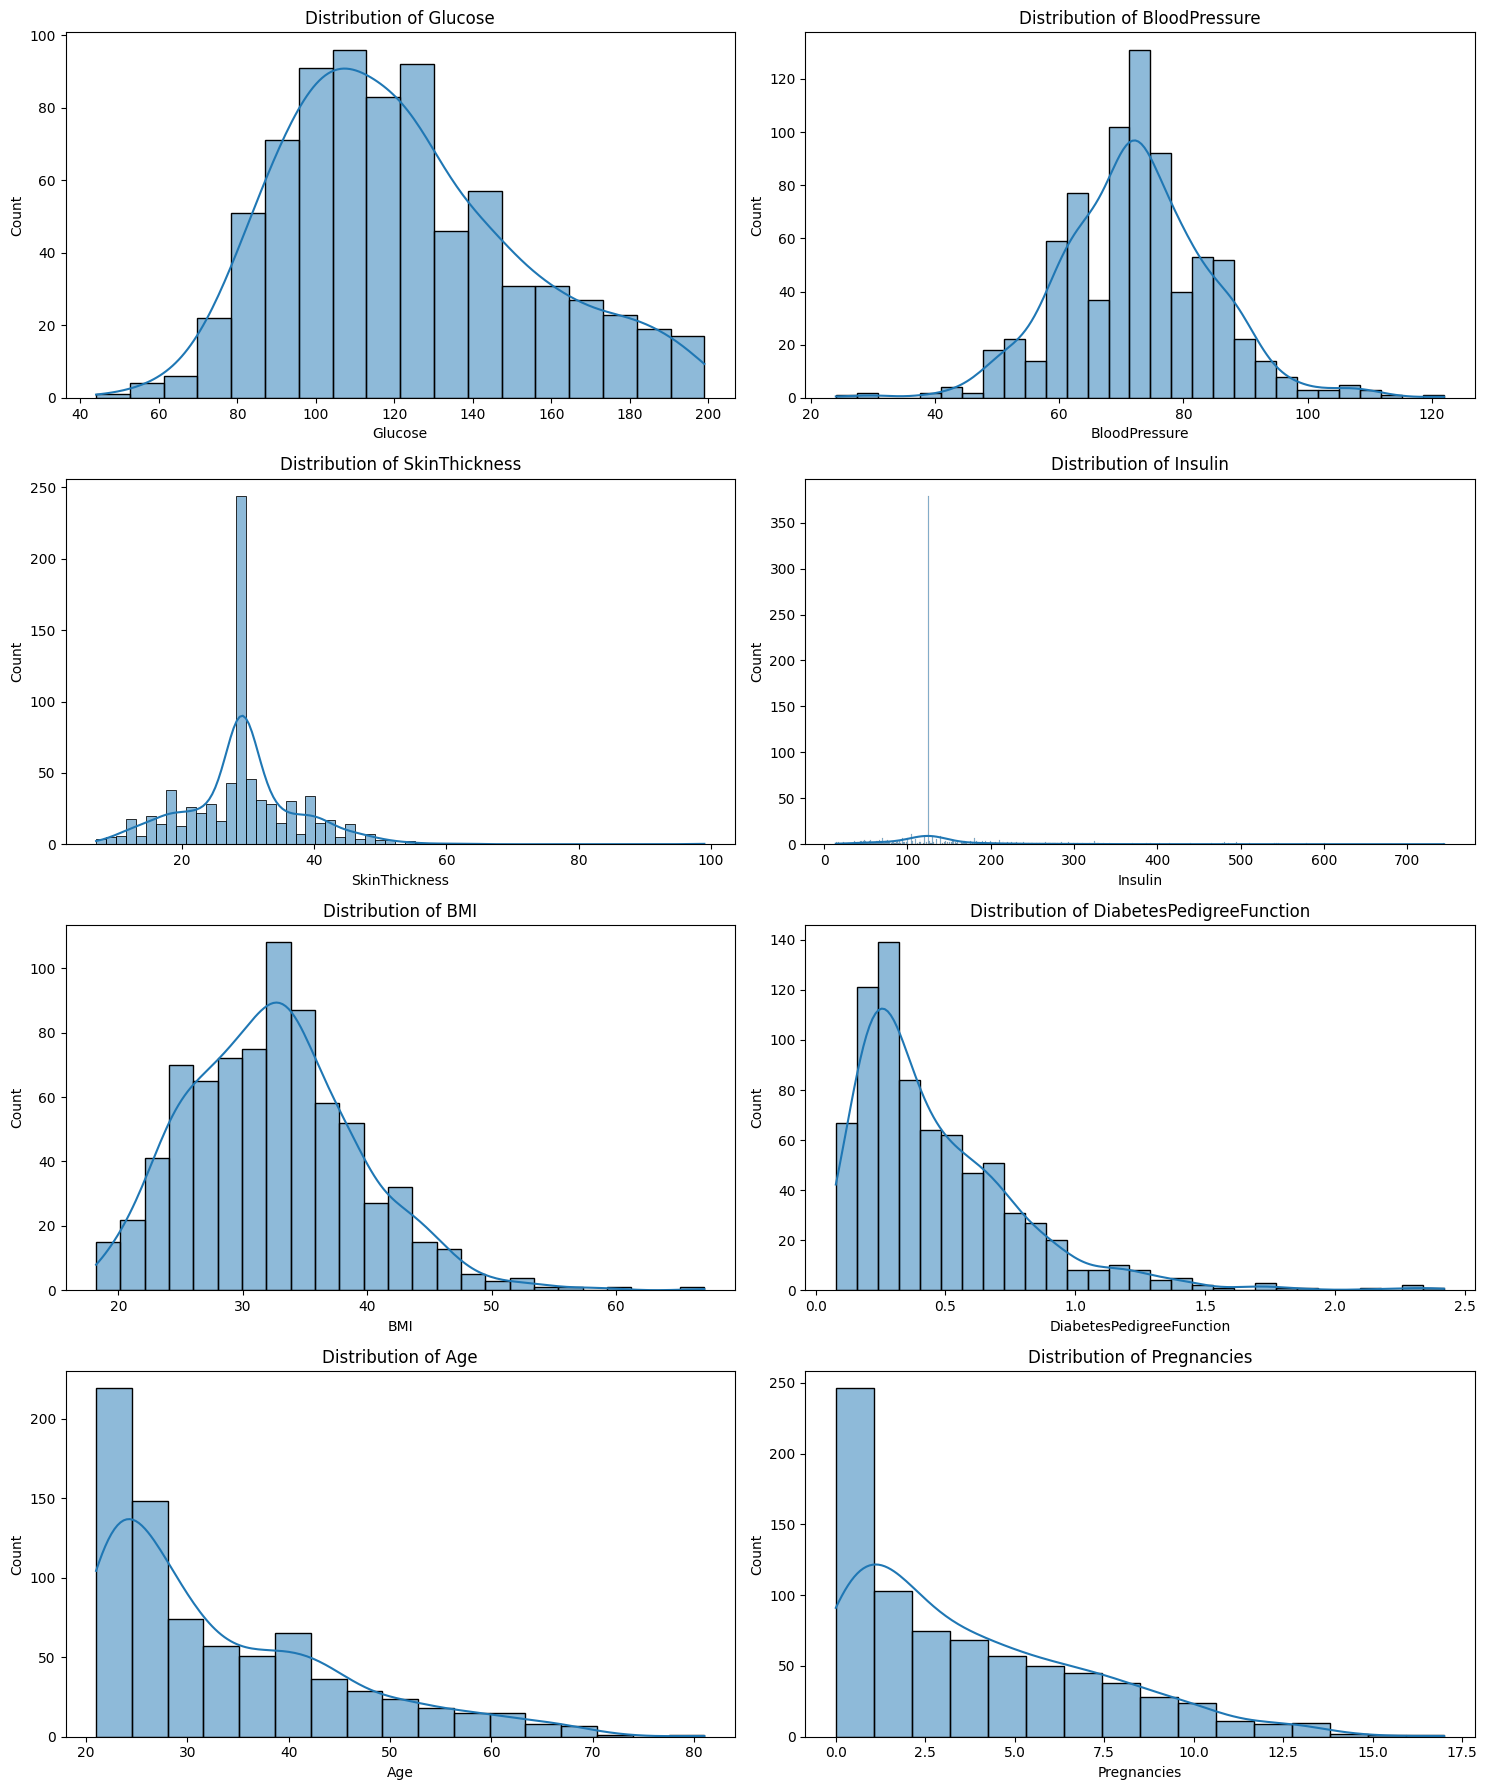

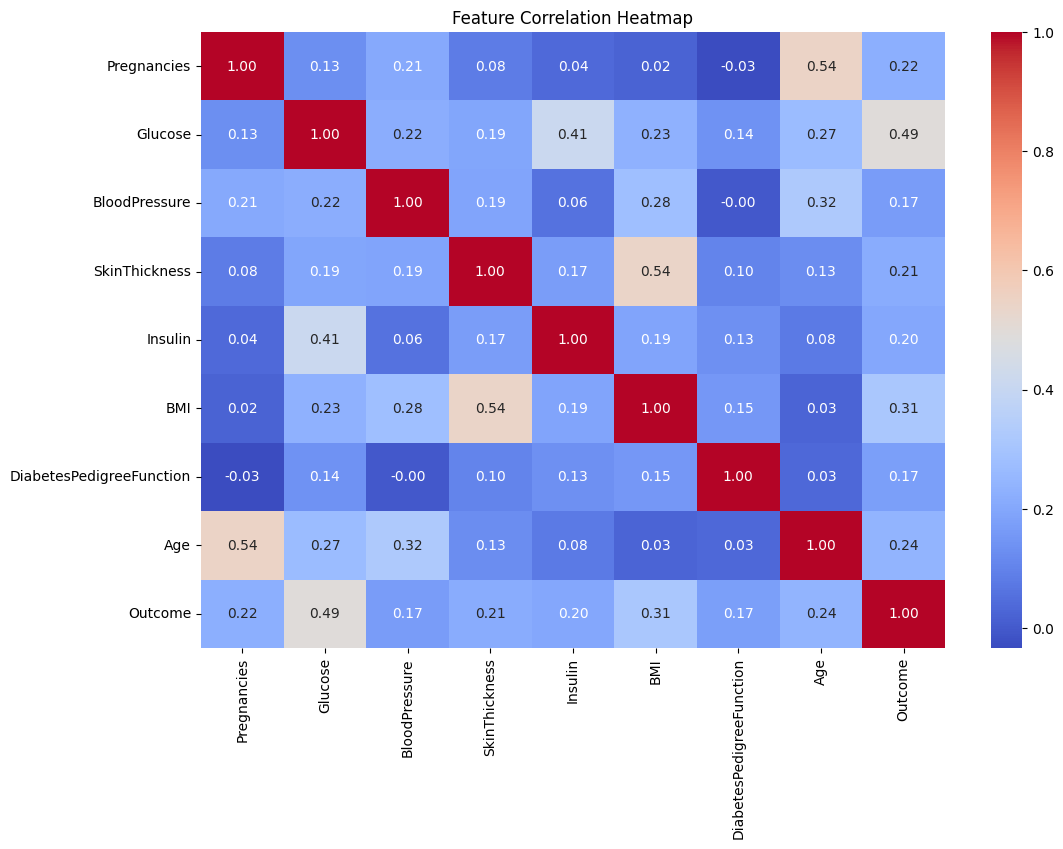

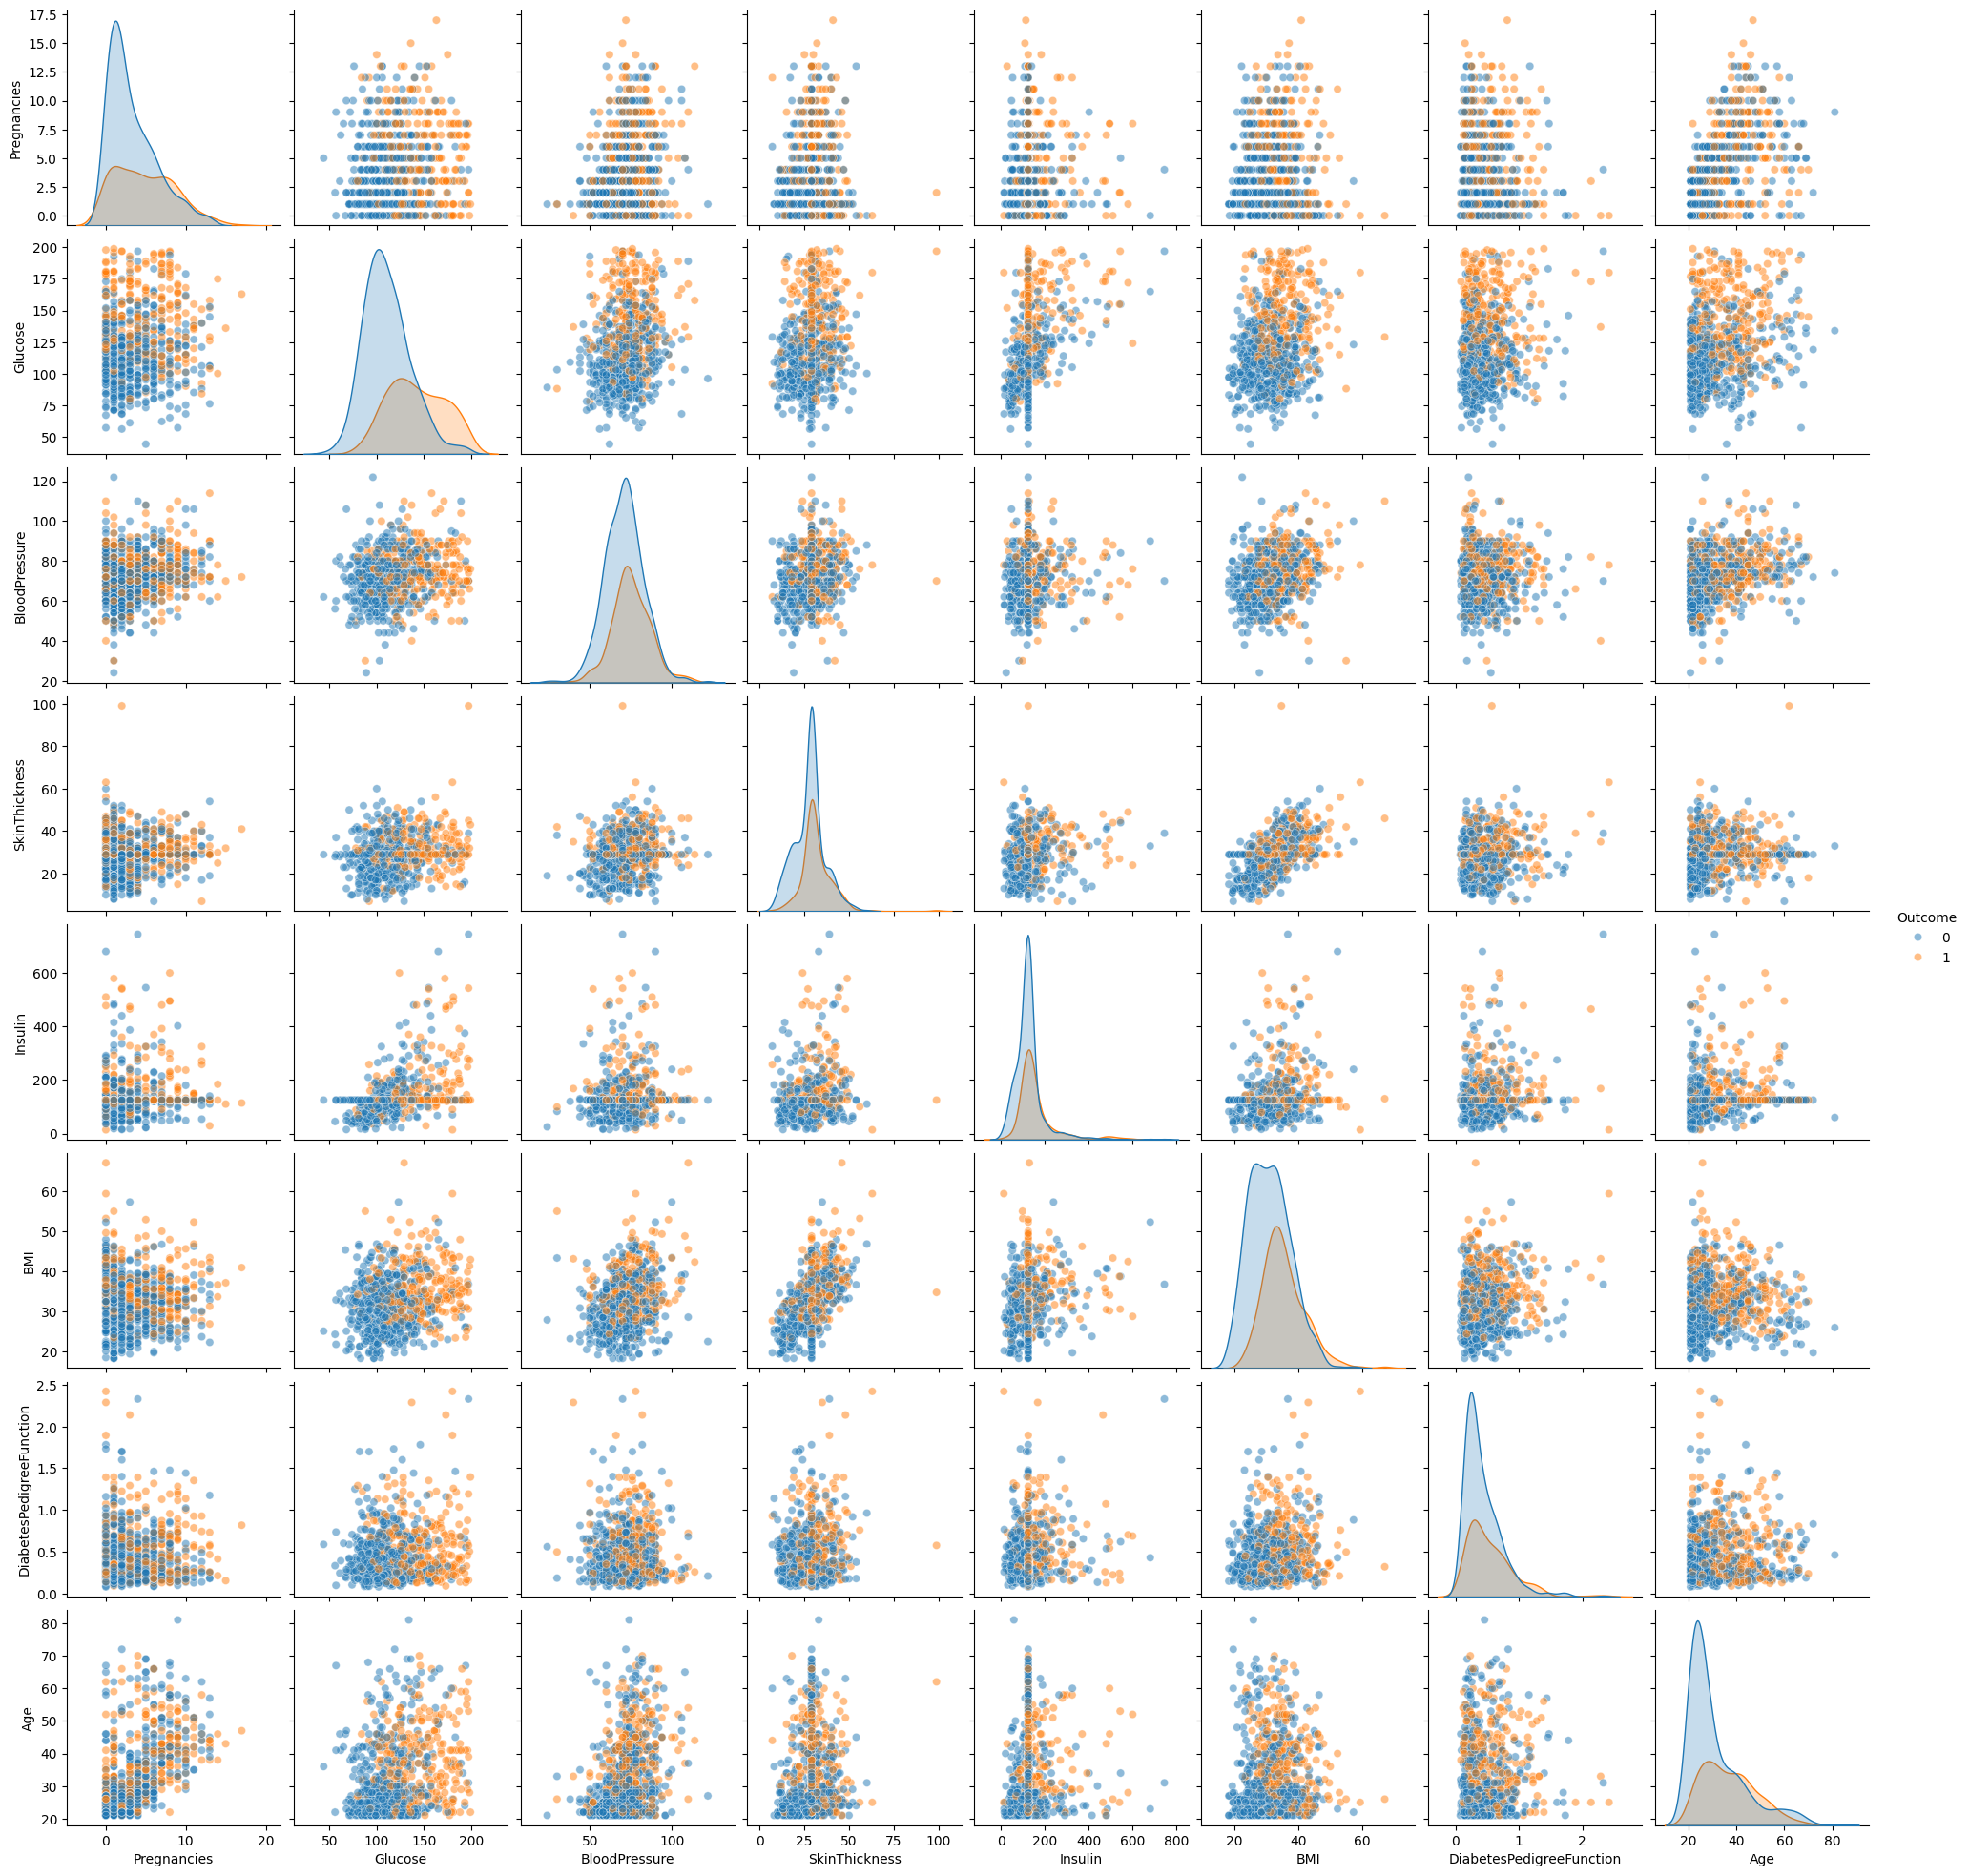

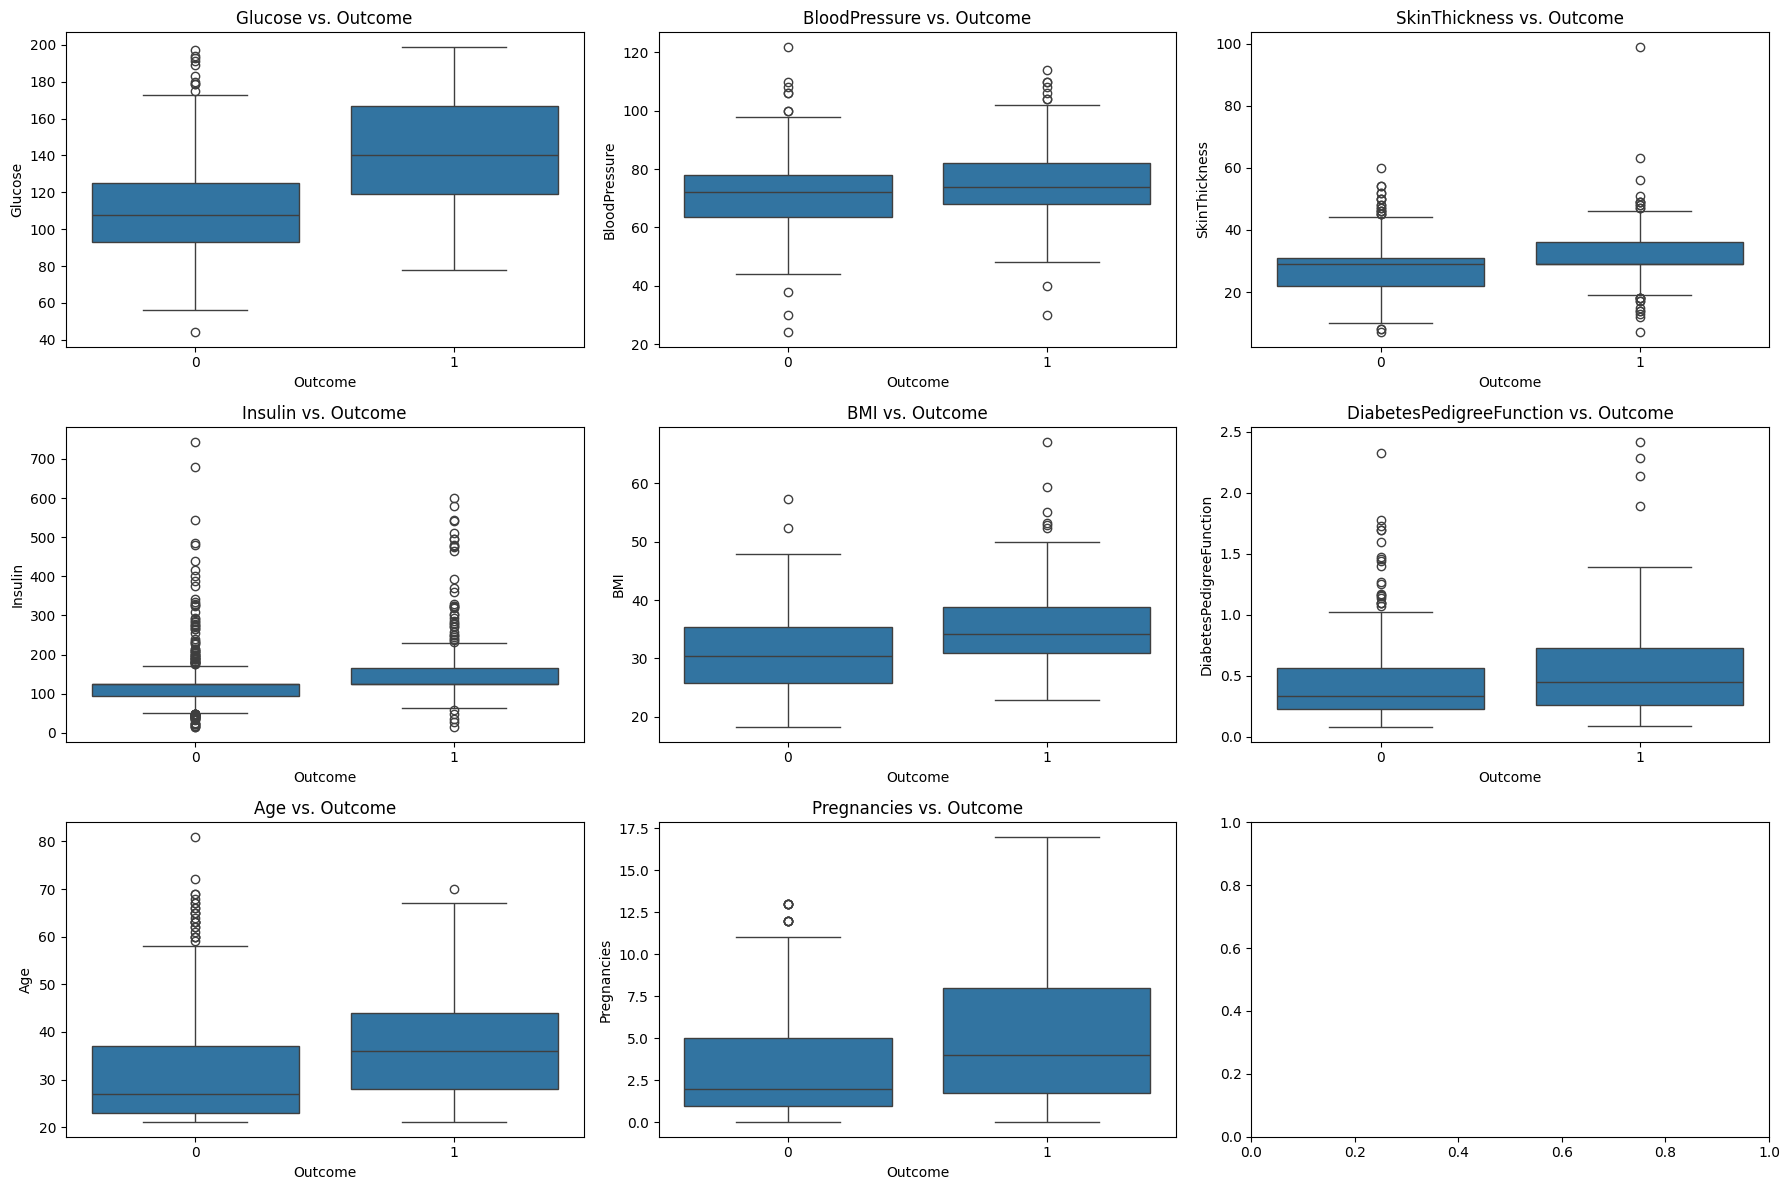

✅ Initial Model Accuracy: 0.7468
✅ Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
✅ Optimized Model Accuracy: 0.7403


In [2]:
# Your code here
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
diabetes_data = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv')

# --- Step 1: Basic Data Overview ---
print("🔹 Dataset Shape:", diabetes_data.shape)
print("\n🔹 Dataset Info:\n", diabetes_data.info())
print("\n🔹 Summary Statistics:\n", diabetes_data.describe().T)
print("\n🔹 Checking for Missing Values:\n", diabetes_data.isnull().sum())

# --- Step 2: Handle Duplicates ---
print("\n🔹 Checking for Duplicate Rows:", diabetes_data.duplicated().sum())

if diabetes_data.duplicated().sum() != 0:
    diabetes_data.drop_duplicates(inplace=True)
    print("✅ Duplicates removed.")

# --- Step 3: Handle Impossible Zero Values ---
# Certain columns like Glucose, Blood Pressure, Skin Thickness, Insulin, and BMI cannot realistically be 0
invalid_zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_data[invalid_zero_columns] = diabetes_data[invalid_zero_columns].replace(0, np.nan)

# Fill missing values with median
for col in invalid_zero_columns:
    diabetes_data[col].fillna(diabetes_data[col].median(), inplace=True)

print("\n🔹 Missing values after correction:\n", diabetes_data.isnull().sum())

# --- Step 4: Handle Outliers ---
# Replace extremely high insulin values (e.g., 846) with median
highest_insulin = diabetes_data[diabetes_data['Insulin'] == 846]
diabetes_data.loc[highest_insulin.index, 'Insulin'] = diabetes_data["Insulin"].median()

# --- Step 5: Feature Distributions & Univariate Analysis ---
fig, axes = plt.subplots(4, 2, figsize=(15, 18))

features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies']

for i, feature in enumerate(features):
    row, col = divmod(i, 2)
    sns.histplot(diabetes_data[feature], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"Distribution of {feature}")
    axes[row, col].set_xlabel(feature)

plt.tight_layout()
plt.show()

# Key Takeaways from Univariate Analysis:
# - Glucose and BMI distributions are right-skewed, which indicates some very high values.
# - Insulin has a high peak at zero, suggesting many missing values were originally present.
# - Age and Pregnancies show a normal-like distribution but with some extreme values.

# --- Step 6: Multivariate Analysis ---

# 🔹 Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(diabetes_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# 🔹 Pairplot for Key Variables
sns.pairplot(diabetes_data, hue="Outcome", diag_kind="kde", plot_kws={'alpha':0.5})
plt.show()

# 🔹 Boxplots to Compare Features Across Diabetes Outcomes
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, feature in enumerate(features):
    row, col = divmod(i, 3)
    sns.boxplot(data=diabetes_data, x="Outcome", y=feature, ax=axes[row, col])
    axes[row, col].set_title(f"{feature} vs. Outcome")

plt.tight_layout()
plt.show()

# Key Insights from Multivariate Analysis:
# - People with diabetes (Outcome=1) tend to have higher Glucose and BMI.
# - Insulin levels and Skin Thickness show wide variations across diabetic and non-diabetic groups.
# - The correlation heatmap shows that Glucose has the strongest positive correlation with diabetes.

# --- Step 7: Train-Test Split for Modeling ---
from sklearn.model_selection import train_test_split

X = diabetes_data.drop(['Outcome'], axis=1)
y = diabetes_data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=117)


# --- Step 8: Train XGBoost Model ---
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(random_state=117)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

model_accuracy = accuracy_score(y_test, y_pred)
print(f'✅ Initial Model Accuracy: {model_accuracy:.4f}')


# --- Step 9: Hyperparameter Optimization with GridSearchCV ---
from sklearn.model_selection import GridSearchCV

hyperparams = hyperparams = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 7,10],
    'subsample': [0.8, 1.0], 
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(model, hyperparams, scoring='accuracy', cv=5)


import warnings
warnings.simplefilter("ignore")

grid.fit(X_train, y_train)
print(f'✅ Best Hyperparameters: {grid.best_params_}')

# Train optimized model
opt_model = XGBClassifier(**grid.best_params_)
opt_model.fit(X_train, y_train)
opt_pred = opt_model.predict(X_test)

opt_accuracy = accuracy_score(y_test, opt_pred)
print(f'✅ Optimized Model Accuracy: {opt_accuracy:.4f}')

# Since the model performs better (higher accuracy score) before applying custom parameters, the original model is saved
from pickle import dump

dump(model, open("../models/boosting_classifier_random_state_117.sav", "wb"))
